In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
import copy
import shap

transaction_df = pd.read_csv('sample_transaction_data.csv')
transaction_df = transaction_df.sample(frac=1)
transaction_df.head()


In [ ]:
transaction_df.drop_duplicates(inplace=True)
for c in transaction_df.columns:
    if len(transaction_df[c].dropna().drop_duplicates())<=1:
        transaction_df.drop(columns = [c],inplace= True)
transaction_df.col_2 = pd.to_numeric(transaction_df.col_2,errors='coerce')
transaction_df.rename(columns = {'col_30':'country'},inplace = True)

In [ ]:
transaction_df

# Slides:
* Model metrics (this is where the real **value** is) (halfway done w code)

* XGBoost + cross validate some regularization.

* Data features:
  * Basic data types, missing data and sparsity.
  * Basic data cleaning
  * Basic analysis.
  * New features: Encoded business name. + age of account. 
* Basic model + SHAP for feature importance. (done w code)
* Challenge: Missing data generalization. (done w code)
  * Missing data imputed by xgboost.
    * How well does it generalize to random missing data.
  * KNN imputed data. + same question.
 

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer, SimpleImputer


import copy
class FraudPreprocessor(): #fixed set of preprocessing options for easy tinkering
    def __init__(self, 
                 nan_threshold = .04,
                 knn_k = None, #k for k nearest neighbor imputer if None, then do not impute.
                ):
        col_num_frac_nan = transaction_df.select_dtypes(np.number).apply(lambda x: sum(x.isna())/len(transaction_df),axis=0)
        self.nan_threshold = nan_threshold
        self.knn_k = knn_k
        self.labels_fit = False
    def fit_train(self,X): # apply to dataframe
        if self.labels_fit == False:
            print('fit label encoders first')
            return
        X = copy.copy(X)
        X.loc[:,'transaction_date'] = pd.to_datetime(X.transaction_date)
        X.loc[:,'account_open_date'] = pd.to_datetime(X.account_open_date)
        
        
        self.col_num_frac_nan = X.select_dtypes(np.number).apply(lambda x: sum(x.isna())/len(X),axis=0).sort_values()
        X['acct_age'] = (X.transaction_date - X.account_open_date).dt.days
        
        self.low_nan_numeric = self.col_num_frac_nan[self.col_num_frac_nan <= self.nan_threshold].index
        #print(self.low_nan_numeric)
        if self.knn_k is not None:
            self.nan_imputer = KNNImputer(n_neighbors=self.knn_k, weights="uniform")
            self.nan_imputer.fit(X[self.low_nan_numeric])
            X.loc[list(X.acct_age.isna()),['acct_age']] = X.loc[list(X.acct_age.isna()==False),['acct_age']].mean()
    def fit_label_encoders(self,X): # sort of messy, but it is necessary

        self.cv = CountVectorizer() # for beneficiary strings
        self.cv.fit(X.beneficiary)
        col_x =  [c for c in transaction_df.columns if c[:4]=='col_']
        self.obj_columns = [c  for c in col_x if X[c].dtype is np.dtype('O')] + ['country']
        self.obj_encoders = {c:OneHotEncoder() for c in self.obj_columns}
        for k in self.obj_encoders.keys():
            self.obj_encoders[k].fit(X[k].to_numpy().reshape((-1,1)))
        self.labels_fit = True
    def transform(self,X): # returns a data frame because it is easier. 
        # X will be of the form [acct age,m,d, parse_beneficiary, categorical data, low_nan_numerics,
        X = copy.copy(X)

        X.loc[:,'transaction_date'] = pd.to_datetime(X.transaction_date)
        X.loc[:,'account_open_date'] = pd.to_datetime(X.account_open_date)
        X['acct_age'] = (X.transaction_date - X.account_open_date).dt.days
        X['month'] = X.loc[:,'transaction_date'].apply(lambda x:x.month)
        X['day'] = X.loc[:,'transaction_date'].apply(lambda x:x.day)
        
        X_numeric = X[self.low_nan_numeric]
        Y = X[['acct_age','month','day']]
        X_numeric.reindex(index= Y.index)
        if self.knn_k is not None:
            #print('here')
            age_mean = X.loc[X.acct_age.isna()==False,['acct_age']].mean()[0]
            X.acct_age = X.acct_age.fillna(value = age_mean)
            X_numeric = pd.DataFrame(data = self.nan_imputer.transform(X_numeric), columns = self.low_nan_numeric,
                                    index = Y.index)
        
        #print(age_mean)
        Y = X[['acct_age','month','day']]
        #print(X.acct_age.fillna(value = age_mean).isna().any())
        
        #print(len(Y))
        ben_vec = self.cv.transform(X.beneficiary).toarray()
        ben_vec = pd.DataFrame(columns = self.cv.get_feature_names_out(), data = ben_vec, index=Y.index)
        
        
        
        Y = pd.concat([Y,ben_vec,X_numeric],axis = 1,join='inner')
        #print(len(Y),len(X),len(X_numeric),len(ben_vec))
        obj_array =   pd.concat([pd.DataFrame(columns = v.get_feature_names_out() ,
                                              data = self.obj_encoders[k].transform(X[k].to_numpy().reshape((-1,1))).toarray(),
                                             index = Y.index)
                                 for k,v in self.obj_encoders.items()],axis=1,join='inner')
        #print(len(Y))
        bool_col = [c for c in transaction_df.columns if transaction_df[c].dtype is np.dtype('bool')]
        Y = pd.concat([Y,obj_array,X[bool_col]],axis=1, join='inner')
        
        #print(len(Y))
        
        return Y

In [ ]:
import xgboost as xgb


In [655]:
from sklearn.model_selection import train_test_split
df_x = transaction_df.drop(columns = ['transaction_id','targets'])
df_y = transaction_df['targets']
y_all = df_y.to_numpy()

nan_amts = [.04,.6,1]

fp_no_impute = [FraudPreprocessor(nan_threshold = p, knn_k = None) for p in nan_amts]
fp_knn = [FraudPreprocessor(nan_threshold = p, knn_k = 3) for p in nan_amts]
for fp in fp_no_impute: fp.fit_label_encoders(df_x)
for fp in fp_knn: fp.fit_label_encoders(df_x)




x_tr, x_te, y_tr, y_te = train_test_split(df_x, y_all, test_size=0.33,shuffle=True)
print('fitting pre-processor')

for fp in fp_no_impute: fp.fit_train(df_x)
for fp in fp_knn: fp.fit_train(df_x)

from imblearn.over_sampling import KMeansSMOTE, BorderlineSMOTE

tr_knn = []
print('imputing values and re-sampling for class imbalance')
for i,fp in enumerate(fp_knn):
    print(i)
    x_tr_smote, y_tr_smote = BorderlineSMOTE().fit_resample(fp.transform(x_tr), y_tr)
    tr_knn = tr_knn + [xgb.DMatrix(x_tr_smote,label = y_tr_smote)]
print('processing test set')
te_no_impute = [xgb.DMatrix(fp.transform(x_te),y_te) for fp in fp_no_impute]
te_knn = [xgb.DMatrix(fp.transform(x_te),y_te) for fp in fp_knn]

te_no_impute_ = [fp.transform(x_te) for fp in fp_no_impute]
te_knn_ = [fp.transform(x_te) for fp in fp_knn]

fitting pre-processor
imputing values and re-sampling for class imbalance
0
1
2
processing test set


In [ ]:
x_tr, x_te, y_tr, y_te = train_test_split(x_tv, y_tv, test_size=0.33,shuffle=True)

# Metrics:

* precision
* 200*(1 - precision)

* Recalled frauds (recall)
* Recalled Money: Percent of available fraud money captured.

In [ ]:
from sklearn import metrics
ind = 1

param = {'max_depth':20, 'eta':.3,
         'objective':'binary:logistic','lambda':1000, 'alpha':.1}
num_round = 20

dtrain = tr_knn[ind]
dtest = te_knn[ind]

bst = xgb.train(param, dtrain, num_round)
y_pred = bst.predict(dtrain)
#fp_r, tp_r, t = metrics.roc_curve(y_tr, y_pred)

#ax[0].plot(fp_r,tp_r)
#ax[0].set_title('ROC on train')

f,ax = plt.subplots()
y_pred = bst.predict(dtest)
print(y_pred)
fp_r, tp_r, t = metrics.roc_curve(y_te, y_pred)
ax.plot(fp_r,tp_r)
ax.set_title('ROC on test')

f,ax = plt.subplots()
y_pred = bst.predict(dtest)
precision, recall, t = metrics.precision_recall_curve(y_te, y_pred)
precision_amt, recall_amt, t = metrics.precision_recall_curve(y_te, y_pred,sample_weight = x_te.transaction_amount)
ax.plot(precision,recall)
ax.set_title('precision - recall on test')



f,ax = plt.subplots()
ax.plot(recall_amt*(x_te.transaction_amount.sum()),200*(1-precision)*x_te.size)
ax.set_title('precision - recall amounts on test')

f,ax = plt.subplots()
ax.plot(recall_amt*(x_te.transaction_amount.sum())-200*(1-precision)*x_te.size)
ax.set_title('precision - recall amounts on test')


plt.figure()
import shap
y_pred = bst.predict(dtest,output_margin  = True)
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(dtest)
np.abs(shap_values.sum(1) + explainer.expected_value - y_pred).max()
shap.summary_plot(shap_values, te_knn_[ind])



In [ ]:
tree_depths

In [693]:
import time
n_hyper = 20
lambds = np.power(10,np.random.uniform(-2,1,n_hyper))
thetas = np.random.uniform(.5,1,n_hyper)
tree_depths = np.random.randint(1,5,n_hyper)
etas = np.power(2,np.random.uniform(-4,1,n_hyper))
min_child_weights = np.exp(np.random.uniform(-1,2,n_hyper))

model_data = []
best_model = [None for _ in range(len(nan_amts))]
best_model_all = None
MAX_auc = 0

for i, na in enumerate(nan_amts):
    model_data = model_data + [[]]
    max_auc = 0
    for j in range(n_hyper):
        print(i+1,'out of',len(nan_amts),j+1,'out of',n_hyper)
        
        param = {'max_depth': tree_depths[j],
                 'eta':etas[j],
                 'objective':'binary:logistic',
                 'lambda': (1-thetas[j])*lambds[j], 
                 'alpha':(thetas[j])*lambds[j],
                'min_child_weight':min_child_weights[j],
                'eval_metric':'aucpr'}
        hyperparam_dict = copy.copy(param)
        hyperparam_dict['frac_nan']=na
        hyperparam_dict['max_depth'] = tree_depths[j].astype(float)
        
        dtrain = tr_knn[i]
        dtest = te_knn[i]
        start = time.time()        
        
        cv = xgb.cv(param, dtrain, num_boost_round = 300, #evals=[(dtest, "Test")],
                     early_stopping_rounds=10,verbose_eval = 10)
        del(param['eval_metric'])
        bst = xgb.train(param, dtrain, 
                        num_boost_round = cv.iloc[:,2].argmax(), #evals=[(dtest, "Test")],
                     verbose_eval = 10)
        
        
        end = time.time()
        train_time = (end-start)/x_tr.size
        
        start = time.time()  
        y_pred = bst.predict(dtest)
        end = time.time()
        predict_time = (end-start)/x_te.size
        
        precision, recall, t = metrics.precision_recall_curve(y_te, y_pred)
        precision_amt, recall_amt, t_amt = metrics.precision_recall_curve(y_te, y_pred,sample_weight = te_knn_[i].transaction_amount)
        
        fp_amt, tp_amt, trocamt = metrics.roc_curve(y_te, y_pred,sample_weight = te_knn_[i].transaction_amount)
        fp, tp, troc = metrics.roc_curve(y_te, y_pred, drop_intermediate=False)
        
        
        money_saved = tp_amt * np.sum(te_knn_[i].transaction_amount.to_numpy().flatten()*y_te.flatten()) - \
        200*(fp*np.sum(1-y_te) + tp*np.sum(y_te))
        money_saved2 = tp_amt * np.sum(te_knn_[i].transaction_amount.to_numpy().flatten()*y_te.flatten()) - \
        2000*(fp*np.sum(1-y_te) + tp*np.sum(y_te))
        money_saved3 = tp_amt * np.sum(te_knn_[i].transaction_amount.to_numpy().flatten()*y_te.flatten()) - \
        20000*(fp*np.sum(1-y_te) + tp*np.sum(y_te))
        
        
        
        fscores  = 2*precision*recall/(precision+recall)
        
        metric_dict = { 
            'auc_precision_recall': sklearn.metrics.auc(recall, precision),
            'auc_pr_amt_basis': sklearn.metrics.auc(recall_amt, precision),
            'max_money_saved': money_saved.max()/te_knn_[i].size,
            'max_money_saved2000': money_saved2.max()/te_knn_[i].size,
            'max_money_saved20000': money_saved3.max()/te_knn_[i].size,
            'training_time':train_time,
            'prediction_time':predict_time,
            'f1_max': fscores.max()
                      }
        if max_auc < sklearn.metrics.auc(recall_amt, precision):
            max_auc = sklearn.metrics.auc(recall_amt, precision)
            best_model[i] = [bst,dtest,te_knn_[i],max_auc]
        if MAX_auc < sklearn.metrics.auc(recall_amt, precision):
            MAX_auc = sklearn.metrics.auc(recall_amt, precision)
            best_model_all = [bst,dtest,te_knn_[i],MAX_auc]
                              
                       
        performance_dict = {'thresholds_pr': list(t.astype(float)),
                            'precision': list(precision.astype(float)),
                            'recall': list(recall.astype(float)),
                            'recall_amt_basis': list(recall_amt.astype(float)),
                            'money_saved': list(money_saved.astype(float)/y_te.size),
                            'money_saved2000': list(money_saved2.astype(float)/y_te.size),
                            'money_saved20000': list(money_saved2.astype(float)/y_te.size),
                            'thresholds_roc': list(troc.astype(float)),
                            'tp':list(tp)
                           }
        model_data[-1] = model_data[-1] + [{'parameters':hyperparam_dict,
                                    'metrics':metric_dict,
                                    'performance':performance_dict}
                                  ]


1 out of 3 1 out of 20
[0]	train-aucpr:0.98453+0.00094	test-aucpr:0.98388+0.00077
[10]	train-aucpr:0.99861+0.00031	test-aucpr:0.99769+0.00034
[20]	train-aucpr:0.99970+0.00007	test-aucpr:0.99937+0.00014
[30]	train-aucpr:0.99987+0.00003	test-aucpr:0.99961+0.00008
[40]	train-aucpr:0.99992+0.00001	test-aucpr:0.99967+0.00007
[50]	train-aucpr:0.99995+0.00001	test-aucpr:0.99971+0.00005
[60]	train-aucpr:0.99997+0.00001	test-aucpr:0.99973+0.00005
[70]	train-aucpr:0.99999+0.00000	test-aucpr:0.99975+0.00005
[80]	train-aucpr:0.99999+0.00000	test-aucpr:0.99975+0.00005
[85]	train-aucpr:0.99999+0.00000	test-aucpr:0.99975+0.00005
1 out of 3 2 out of 20
[0]	train-aucpr:0.98455+0.00093	test-aucpr:0.98378+0.00058
[10]	train-aucpr:0.99871+0.00032	test-aucpr:0.99771+0.00052
[20]	train-aucpr:0.99967+0.00007	test-aucpr:0.99933+0.00007
[30]	train-aucpr:0.99985+0.00004	test-aucpr:0.99956+0.00006
[40]	train-aucpr:0.99992+0.00002	test-aucpr:0.99965+0.00006
[50]	train-aucpr:0.99995+0.00002	test-aucpr:0.99969+0.00

KeyboardInterrupt: 

In [725]:
bm0 = get_best_model([get_best_model(md,'auc_pr_amt_basis') for md in model_data],'auc_pr_amt_basis')
bm0['parameters']

{'max_depth': 1.0,
 'eta': 0.26311873673086844,
 'objective': 'binary:logistic',
 'lambda': 0.004981642044976639,
 'alpha': 0.011642538946814829,
 'min_child_weight': 4.460561025592723,
 'eval_metric': 'aucpr',
 'frac_nan': 0.6}

1.0
0.996078431372549
1.0
1.0


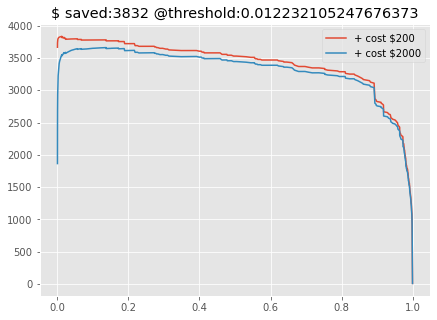

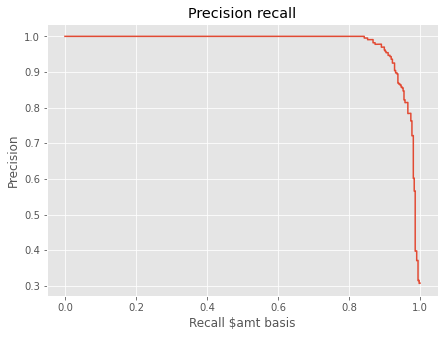

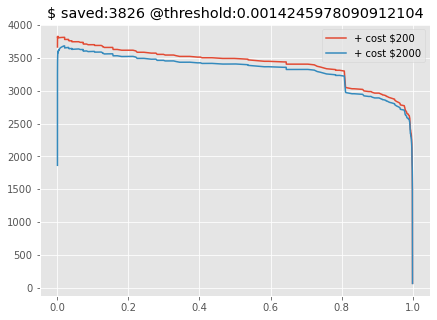

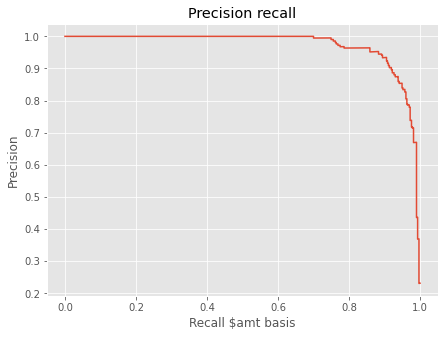

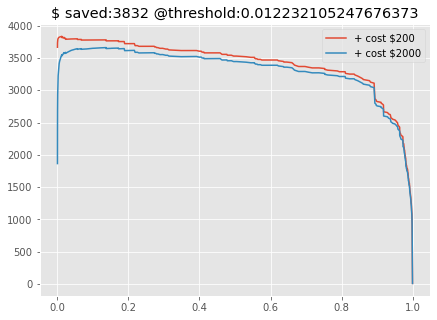

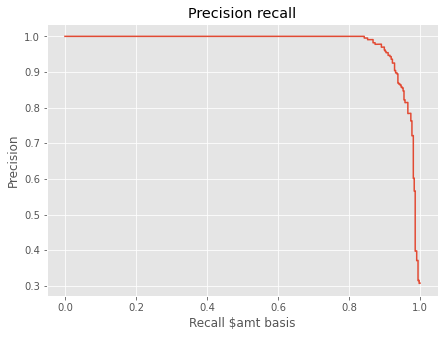

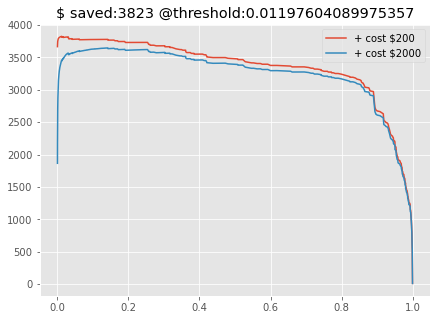

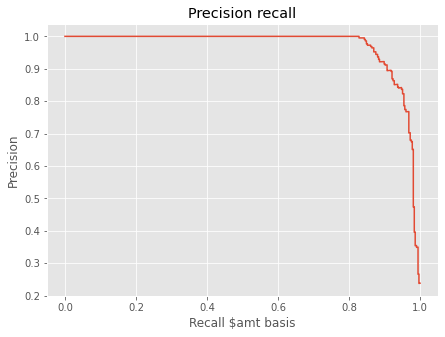

In [707]:
a = 0 ; b=9
plt.style.use('ggplot')

bm0 = get_best_model([get_best_model(md,'auc_pr_amt_basis') for md in model_data],'auc_pr_amt_basis')
f,ax = plt.subplots(1,1,figsize = (7,5))
ax.plot(bm0['performance']['thresholds_roc'][1:],bm0['performance']['money_saved'][1:],label = '+ cost $200')
ax.plot(bm0['performance']['thresholds_roc'][1:],bm0['performance']['money_saved2000'][1:],label = '+ cost $2000')
np.argmax(bm0['performance']['money_saved'][1:])
ind = np.argmax(bm0['performance']['money_saved'])
thresh= bm0['performance']['thresholds_roc'][ind]
ax.set_title('$ saved:' +str(int(np.max(bm0['performance']['money_saved'])))+' @threshold:'+str(thresh))
ax.legend()
print(bm0['performance']['tp'][ind])
f,ax = plt.subplots(1,1,figsize = (7,5))
ax.plot(bm0['performance']['recall_amt_basis'],bm0['performance']['precision'])
ax.set_xlabel('Recall $amt basis')
ax.set_ylabel('Precision')
ax.set_title('Precision recall')
             
             
for bm0 in [get_best_model(md,'auc_pr_amt_basis') for md in model_data]:
    f,ax = plt.subplots(1,1,figsize = (7,5))
    ax.plot(bm0['performance']['thresholds_roc'][1:],bm0['performance']['money_saved'][1:],label = '+ cost $200')
    ax.plot(bm0['performance']['thresholds_roc'][1:],bm0['performance']['money_saved2000'][1:],label = '+ cost $2000')
    np.argmax(bm0['performance']['money_saved'][1:])
    ind = np.argmax(bm0['performance']['money_saved'])
    thresh= bm0['performance']['thresholds_roc'][ind]
    ax.set_title('$ saved:' +str(int(np.max(bm0['performance']['money_saved'])))+' @threshold:'+str(thresh))
    ax.legend()
    print(bm0['performance']['tp'][ind])
    f,ax = plt.subplots(1,1,figsize = (7,5))
    ax.plot(bm0['performance']['recall_amt_basis'],bm0['performance']['precision'])
    ax.set_xlabel('Recall $amt basis')
    ax.set_ylabel('Precision')
    ax.set_title('Precision recall')
                

        

In [624]:
def get_best_model(model_list,metric):
    i = np.argmax([m['metrics'][metric] for m in model_list])
    return model_list[i]

bm0 = get_best_model(model_data[1],'auc_pr_amt_basis')


In [ ]:
bm0['performance']
x_te.transaction_amount

In [ ]:
model_data[-1][0]['performance']['thresholds_roc'][0]

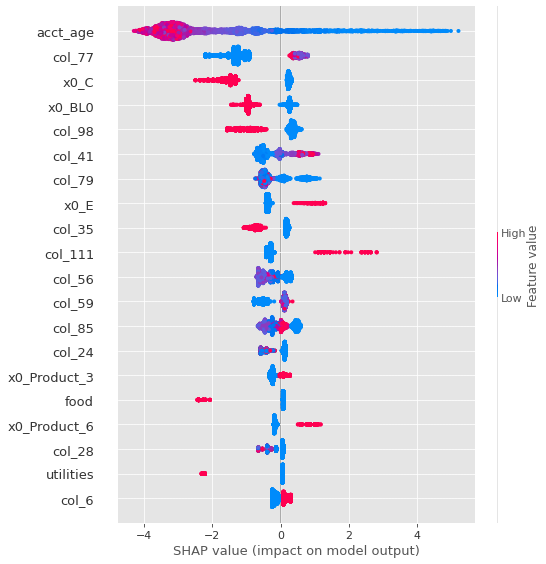

In [708]:
import shap
y_pred = best_model_all[0].predict(best_model_all[1],output_margin  = True)
explainer = shap.TreeExplainer(best_model_all[0])
shap_values = explainer.shap_values(best_model_all[1],check_additivity=False)
np.abs(shap_values.sum(1) + explainer.expected_value - y_pred).max()
shap.summary_plot(shap_values, best_model_all[2])


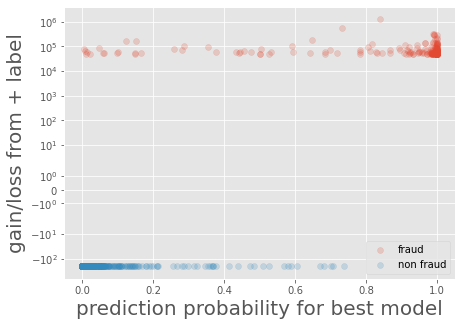

In [726]:
y_pred = best_model_all[0].predict(best_model_all[1])
plt.figure(figsize=(7,5))
plt.scatter(y_pred[y_te>0],(y_te*x_te.transaction_amount)[y_te>0],label = 'fraud',alpha=.2)
plt.scatter(y_pred[y_te==0],((y_te-1)*200)[y_te==0],label = 'non fraud',alpha=.2)
plt.ylabel('gain/loss from + label',fontsize=20)
plt.xlabel('prediction probability for best model',fontsize=20)
plt.yscale('symlog')
plt.legend()


In [616]:
import json
with open('model_metrics.json','w') as mm:
    json.dump(model_data[0][0]['performance'],mm)

In [ ]:
a = model_data[0][0]
type(a['parameters']['eta'])
a['parameters']['eta']

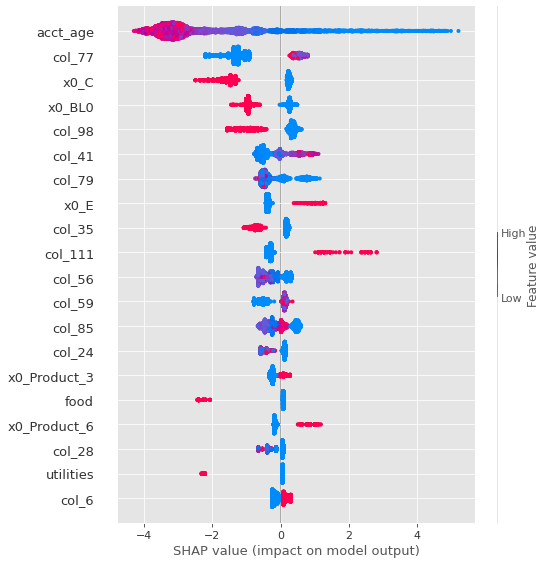

0.980194041990294


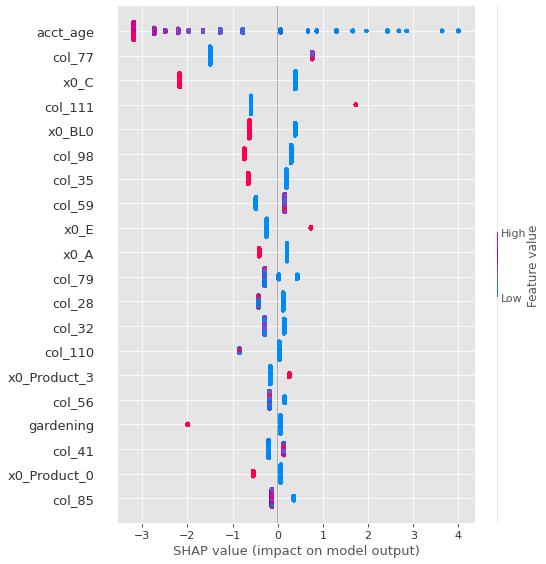

0.9774520758089478


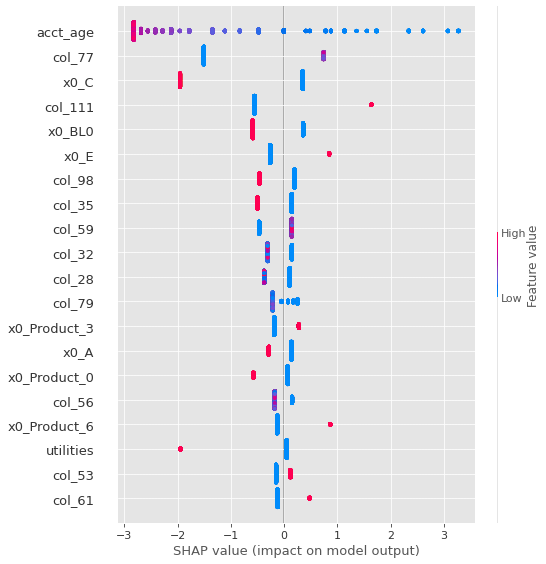

0.9703593640608265


In [724]:
for bm in best_model:
    plt.figure()
    y_pred = bm[0].predict(bm[1],output_margin  = True)
    explainer = shap.TreeExplainer(bm[0])
    shap_values = explainer.shap_values(bm[1])
    np.abs(shap_values.sum(1) + explainer.expected_value - y_pred).max()
    shap.summary_plot(shap_values, bm[2])
    print(bm[3])

In [ ]:
model_data[;

In [ ]:
[m['metric']['auc_pr_amt_basis'] for m in model_data]

In [ ]:
plt.plot(performance_dict['thresholds_amt']+[1],performance_dict['money_saved'])

In [ ]:
x0 = fp_knn[0].transform(x_tr)
x1 = fp_knn[1].transform(x_te)



In [ ]:
performance_dict['thresholds_amt'][-1]